# 12 Month EPS Growth Regression Model

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Manipulate to get proper monthly EPS growth

Use PE ratio, average monthly prices, and the 10-Year Treasury Yield to calculate the proper EPS growth

In [2]:
# load average monthly price
pe_df = pd.read_csv('Normalized_PE.csv')
# convert proper types
pe_df['Dates']= pd.to_datetime(pe_df['Dates'])
# check for types
pe_df.dtypes

Dates    datetime64[ns]
PE              float64
dtype: object

In [3]:
# get average per year, month
pe_df = pe_df.groupby([(pe_df.index.year), (pe_df.index.month)]).PE.mean()



AttributeError: 'RangeIndex' object has no attribute 'year'

In [14]:
# remove useless columns
pe_df = pe_df.iloc[:,0:2]
# remove useless string character at the end
pe_df['Close'] = pe_df['Close'].str[:-1]
# rename columns
pe_df = pe_df.rename(columns={"Unnamed: 0": "Date"})
# convert to proper date time type
pe_df['Date']= pd.to_datetime(pe_df['Date'])
pe_df['Close'] = pe_df['Close'].astype(float)
# check proper types
pe_df.dtypes

KeyError: 'Close'

In [ ]:
# Get year and moth separately for joining later
pe_df['Year'] = pd.DatetimeIndex(pe_df.Dates).year
pe_df['Month'] = pd.DatetimeIndex(pe_df.Dates).month

In [5]:
# examine P/E ratios
pe_df.head(5)

,Date,Close,Year,Month
0,2001-10-31,18.16,2001,10
1,2001-11-30,20.71,2001,11
2,2001-12-31,21.17,2001,12
3,2002-01-31,20.19,2002,1
4,2002-02-28,19.91,2002,2


Load monthly earnings prices

In [33]:
# load average monthly price
avg_m_price = pd.read_csv('avg_m_price.csv')
# convert proper types
avg_m_price['Dates']= pd.to_datetime(avg_m_price['Dates'])
# check for types
avg_m_price.dtypes

Dates    datetime64[ns]
Value           float64
dtype: object

In [35]:
avg_m_price = avg_m_price.set_index('Dates')
# get average per year, month
avg_m_price = avg_m_price.groupby([(avg_m_price.index.year), (avg_m_price.index.month)]).Value.mean()
# convert to data frame
avg_m_price = pd.DataFrame(avg_m_price)
# rename, reset index
avg_m_price.index.names=['Year', 'Month']
avg_m_price =avg_m_price.reset_index()
# convert proper type
avg_m_price['Month'] = avg_m_price['Month'].astype(int)

In [36]:
avg_m_price.head(5)

,Year,Month,Value
0,2001,8,368.566087
1,2001,9,323.474000
2,2001,10,332.585652
3,2001,11,348.135714
4,2001,12,350.799500


### Join pe and average earnings together

In [10]:
joined = pd.merge(pe_df, avg_m_price,  how='inner', left_on=['Year','Month'], right_on = ['Year', 'Month'])

# get monthly earnings by dividing the two
joined['m_earnings'] = joined['Value']/joined['Close']

# shift monthly earning for later's monthly earning 
joined['prev_m'] = joined['m_earnings'].shift(1)

# calculate monthly EPS growth without subtracting the 10 year yield
joined['EPS_growth'] = ((joined['m_earnings'] - joined['prev_m']) / joined['prev_m'] + 1.0)**12 - 1

In [11]:
joined.head(5)

,Date,Close,Year,Month,Value,m_earnings,prev_m,EPS_growth
0,2001-10-31,18.16,2001,10,332.585652,18.314188,NaN,NaN
1,2001-11-30,20.71,2001,11,348.135714,16.810030,18.314188,-0.642423
2,2001-12-31,21.17,2001,12,350.799500,16.570595,16.810030,-0.158148
3,2002-01-31,20.19,2002,1,354.028571,17.534848,16.570595,0.971363
4,2002-02-28,19.91,2002,2,337.302632,16.941368,17.534848,-0.338458


### Load 10-year treasury

In [13]:
treasury = pd.read_csv('mth_treasury_10yr.csv')

# offset by one day to match the proper month later
treasury['DATE'] = pd.to_datetime(treasury['DATE'])
treasury['DATE'] = pd.DatetimeIndex(treasury['DATE'] - pd.DateOffset(1))

# get separate year and month for joining later
treasury['Year'] = pd.DatetimeIndex(treasury.DATE).year
treasury['Month'] = pd.DatetimeIndex(treasury.DATE).month

treasury['10year'] = (treasury['GS10']/100).shift(1)

In [14]:
treasury.head(5)

,DATE,GS10,Year,Month
0,1953-03-31,2.83,1953,3
1,1953-04-30,3.05,1953,4
2,1953-05-31,3.11,1953,5
3,1953-06-30,2.93,1953,6
4,1953-07-31,2.95,1953,7


Join to calculate the final monthly eps growth

In [18]:
new_joined = pd.merge(joined, treasury,  how='inner', left_on=['Year','Month'], right_on = ['Year', 'Month'])

new_joined['final_EPS_growth'] = new_joined['EPS_growth'] - new_joined['GS10']

In [19]:
new_joined.head(5)

,Date,Close,Year,Month,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,final_EPS_growth
0,2001-10-31,18.16,2001,10,332.585652,18.314188,NaN,NaN,2001-10-31,4.65,NaN
1,2001-11-30,20.71,2001,11,348.135714,16.810030,18.314188,-0.642423,2001-11-30,5.09,-5.732423
2,2001-12-31,21.17,2001,12,350.799500,16.570595,16.810030,-0.158148,2001-12-31,5.04,-5.198148
3,2002-01-31,20.19,2002,1,354.028571,17.534848,16.570595,0.971363,2002-01-31,4.91,-3.938637
4,2002-02-28,19.91,2002,2,337.302632,16.941368,17.534848,-0.338458,2002-02-28,5.28,-5.618458


In [20]:
# 12 positive growths out of the rest
new_joined[new_joined['final_EPS_growth'] >0]

,Date,Close,Year,Month,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,final_EPS_growth
82,2008-08-31,13.19,2008,8,282.489048,21.416910,15.520666,46.660394,2008-08-31,3.69,42.970394
91,2009-05-31,17.53,2009,5,159.773000,9.114261,7.356118,12.088014,2009-05-31,3.72,8.368014
99,2010-01-31,14.50,2010,1,199.084737,13.729982,8.697705,238.432769,2010-01-31,3.69,234.742769
100,2010-02-28,11.68,2010,2,191.584737,16.402803,13.729982,7.452345,2010-02-28,3.73,3.722345
129,2012-07-31,13.64,2012,7,195.765238,14.352290,13.144704,1.871077,2012-07-31,1.68,0.191077
179,2016-09-30,14.60,2016,9,323.171429,22.135029,18.253496,9.111335,2016-09-30,1.76,7.351335
211,2019-05-31,15.57,2019,5,448.467273,28.803293,24.785017,5.067852,2019-05-31,2.07,2.997852
220,2020-02-29,12.69,2020,2,500.585789,39.447265,29.382025,33.294305,2020-02-29,0.87,32.424305
224,2020-06-30,15.31,2020,6,401.248182,26.208242,23.863708,2.078929,2020-06-30,0.62,1.458929
226,2020-08-31,18.06,2020,8,411.053810,22.760455,21.478509,1.005033,2020-08-31,0.68,0.325033


<AxesSubplot:xlabel='Date'>

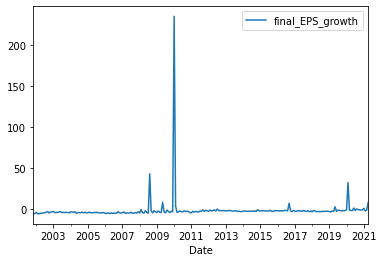

In [21]:
new_joined.loc[1:,['Date','final_EPS_growth']].set_index('Date').plot()

In [23]:
# make a copy
final_df = new_joined.copy()

Create placeholder columns for independent variables


In [24]:
final_df['fed'] = None
final_df['pmi'] = None
final_df['consumer'] = None
final_df['bci_data'] = None

Create placeholder columns for dependent variables, which are future 12-month EPS growth rate

In [25]:
final_df['EPS_1'] = None
final_df['EPS_2'] = None
final_df['EPS_3'] = None
final_df['EPS_4'] = None
final_df['EPS_5'] = None
final_df['EPS_6'] = None
final_df['EPS_7'] = None
final_df['EPS_8'] = None
final_df['EPS_9'] = None
final_df['EPS_10'] = None
final_df['EPS_11'] = None
final_df['EPS_12'] = None

In [27]:
# convert to proper types
final_df['EPS_1'] = final_df['EPS_1'].astype(float)
final_df['EPS_2'] = final_df['EPS_2'].astype(float)
final_df['EPS_3'] = final_df['EPS_3'].astype(float)
final_df['EPS_4'] = final_df['EPS_4'].astype(float)
final_df['EPS_5'] = final_df['EPS_5'].astype(float)
final_df['EPS_6'] = final_df['EPS_6'].astype(float)
final_df['EPS_7'] = final_df['EPS_7'].astype(float)
final_df['EPS_8'] = final_df['EPS_8'].astype(float)
final_df['EPS_9'] = final_df['EPS_9'].astype(float)
final_df['EPS_10'] = final_df['EPS_10'].astype(float)
final_df['EPS_11'] = final_df['EPS_11'].astype(float)
final_df['EPS_12'] = final_df['EPS_12'].astype(float)

final_df['fed'] = final_df['fed'].astype(float)
final_df['pmi'] = final_df['pmi'].astype(float)
final_df['consumer'] = final_df['consumer'].astype(float)
final_df['bci_data'] = final_df['bci_data'].astype(float)
final_df['final_EPS_growth'] = final_df['final_EPS_growth'].astype(float)

In [36]:
# fill the future 12 monthly eps growths
for index, row in final_df.iterrows():
    if row['Date'] > pd.Timestamp(year=2020, month=4, day=30, hour=0):
        break
    i = 1
    for i2, row2 in final_df.iterrows():
        if row2['Date'] > row['Date']:
            col_name = 'EPS_' + str(i)
            final_df.at[index, col_name] = row2['final_EPS_growth']
            i+=1
            if(i > 12):
                break

In [37]:
final_df

,Date,Close,Year,Month,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,...,EPS_3,EPS_4,EPS_5,EPS_6,EPS_7,EPS_8,EPS_9,EPS_10,EPS_11,EPS_12
0,2001-10-31,18.16,2001,10,332.585652,18.314188,NaN,NaN,2001-10-31,4.65,...,-3.938637,-5.618458,-5.523200,-4.956596,-4.785490,-4.708093,-4.340385,-3.618538,-2.870422,-4.564711
1,2001-11-30,20.71,2001,11,348.135714,16.810030,18.314188,-0.642423,2001-11-30,5.09,...,-5.618458,-5.523200,-4.956596,-4.785490,-4.708093,-4.340385,-3.618538,-2.870422,-4.564711,-3.385896
2,2001-12-31,21.17,2001,12,350.799500,16.570595,16.810030,-0.158148,2001-12-31,5.04,...,-5.523200,-4.956596,-4.785490,-4.708093,-4.340385,-3.618538,-2.870422,-4.564711,-3.385896,-3.289232
3,2002-01-31,20.19,2002,1,354.028571,17.534848,16.570595,0.971363,2002-01-31,4.91,...,-4.956596,-4.785490,-4.708093,-4.340385,-3.618538,-2.870422,-4.564711,-3.385896,-3.289232,-2.905550
4,2002-02-28,19.91,2002,2,337.302632,16.941368,17.534848,-0.338458,2002-02-28,5.28,...,-4.785490,-4.708093,-4.340385,-3.618538,-2.870422,-4.564711,-3.385896,-3.289232,-2.905550,-4.149363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2020-12-31,20.16,2020,12,476.858182,23.653680,23.448289,0.110326,2020-12-31,1.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,2021-01-31,19.30,2021,1,504.580000,26.144041,23.653680,2.324208,2021-01-31,1.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,2021-02-28,21.37,2021,2,524.801579,24.557865,26.144041,-0.528138,2021-02-28,1.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,2021-03-31,22.19,2021,3,563.589565,25.398358,24.557865,0.497547,2021-03-31,1.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Load independ variables

In [28]:
import quandl
quandl.ApiConfig.api_key = 'AtPuHRXs-rLGozrAYSKk'

fed_funds_data = quandl.get("FRED/FEDFUNDS", collapse="monthly")

fed_funds_data = fed_funds_data[fed_funds_data.index >= pd.Timestamp(year=2001, month=9, day=30, hour=0)]

fed_funds_data

,Value
Date,
2001-09-30,3.07
2001-10-31,2.49
2001-11-30,2.09
2001-12-31,1.82
2002-01-31,1.73
...,...
2021-03-31,0.07
2021-04-30,0.07
2021-05-31,0.06


In [40]:
bci_data = pd.read_csv('BCI_data.csv')

bci_data['TIME'] = pd.to_datetime(bci_data['TIME'])

bci_data = bci_data[bci_data.TIME >= pd.Timestamp(year=2001, month=9, day=30, hour=0)]

bci_data

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
621,USA,BCI,AMPLITUD,LTRENDIDX,M,2001-10-01,97.84437,NaN
622,USA,BCI,AMPLITUD,LTRENDIDX,M,2001-11-01,97.99640,NaN
623,USA,BCI,AMPLITUD,LTRENDIDX,M,2001-12-01,98.46352,NaN
624,USA,BCI,AMPLITUD,LTRENDIDX,M,2002-01-01,99.11134,NaN
625,USA,BCI,AMPLITUD,LTRENDIDX,M,2002-02-01,99.78757,NaN
...,...,...,...,...,...,...,...,...
854,USA,BCI,AMPLITUD,LTRENDIDX,M,2021-03-01,102.13000,NaN
855,USA,BCI,AMPLITUD,LTRENDIDX,M,2021-04-01,102.03050,NaN
856,USA,BCI,AMPLITUD,LTRENDIDX,M,2021-05-01,101.88540,NaN
857,USA,BCI,AMPLITUD,LTRENDIDX,M,2021-06-01,101.70810,NaN


In [29]:
pmi_data = quandl.get("ISM/MAN_PMI", collapse="monthly")

pmi_data = pmi_data[pmi_data.index >= pd.Timestamp(year=2001, month=9, day=30, hour=0)]

pmi_data

,PMI
Date,
2001-09-30,46.2
2001-10-31,40.8
2001-11-30,44.1
2001-12-31,45.3
2002-01-31,47.5
...,...
2021-03-31,64.7
2021-04-30,60.7
2021-05-31,61.2


In [30]:
consumer_conf_data = quandl.get("BCB/4393", collapse="monthly")

consumer_conf_data = consumer_conf_data[consumer_conf_data.index >= pd.Timestamp(year=2001, month=9, day=30, hour=0)]

consumer_conf_data

,Value
Date,
2001-09-30,90.74
2001-10-31,80.65
2001-11-30,78.31
2001-12-31,86.28
2002-01-31,87.04
...,...
2021-03-31,112.90
2021-04-30,104.95
2021-05-31,105.90


Fill in the independent variables by:
- finding the fed/pmi/consumer/bci that is 1) earlier than the timestamp, and 2) closest to the timestamp

In [38]:
for index, row in final_df.iterrows():
    for i2, row2 in fed_funds_data.iterrows():
        # if earlier, then proceed
        # will stop once it is later than timestamp
        # which achieve the result of finding the closest early data
        if i2 <= row['Date']:
            final_df.at[index, 'fed'] = row2['Value']
            
for index, row in final_df.iterrows():
    for i2, row2 in pmi_data.iterrows():
        if i2 <= row['Date']:
            final_df.at[index, 'pmi'] = row2['PMI']
            
for index, row in final_df.iterrows():
    for i2, row2 in consumer_conf_data.iterrows():
        if i2 <= row['Date']:
            final_df.at[index, 'consumer'] = row2['Value']

for index, row in final_df.iterrows():
    for i2, row2 in bci_data.iterrows():
        if row2['TIME'] <= row['Date']:
            final_df.at[index, 'bci_data'] = row2['Value']

In [42]:
final_df.tail(15)

,Date,Close,Year,Month,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,...,EPS_3,EPS_4,EPS_5,EPS_6,EPS_7,EPS_8,EPS_9,EPS_10,EPS_11,EPS_12
220,2020-02-29,12.69,2020,2,500.585789,39.447265,29.382025,33.294305,2020-02-29,0.87,...,-1.671461,1.458929,-1.558210,0.325033,-0.465789,-0.703413,-1.004688,-0.969674,1.064208,-2.138138
221,2020-03-31,9.95,2020,3,368.297273,37.014801,39.447265,-0.534090,2020-03-31,0.66,...,1.458929,-1.558210,0.325033,-0.465789,-0.703413,-1.004688,-0.969674,1.064208,-2.138138,-1.142453
222,2020-04-30,11.96,2020,4,361.561429,30.230889,37.014801,-0.911914,2020-04-30,0.67,...,-1.558210,0.325033,-0.465789,-0.703413,-1.004688,-0.969674,1.064208,-2.138138,-1.142453,8.162123
223,2020-05-31,15.32,2020,5,365.592000,23.863708,30.230889,-0.941461,2020-05-31,0.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,2020-06-30,15.31,2020,6,401.248182,26.208242,23.863708,2.078929,2020-06-30,0.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,2020-07-31,18.38,2020,7,394.775000,21.478509,26.208242,-0.908210,2020-07-31,0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,2020-08-31,18.06,2020,8,411.053810,22.760455,21.478509,1.005033,2020-08-31,0.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,2020-09-30,17.41,2020,9,405.641905,23.299363,22.760455,0.324211,2020-09-30,0.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228,2020-10-31,17.37,2020,10,409.940000,23.600461,23.299363,0.166587,2020-10-31,0.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,2020-11-30,19.00,2020,11,445.517500,23.448289,23.600461,-0.074688,2020-11-30,0.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# remove the useless last twelve rows because they have no values yet
final_df = final_df.iloc[0:223]

### Modeling regression to predict future 12 monthly EPS growths based on various independent variables

In [103]:
train_X = final_df.iloc[0:199,11:15]
train_y = final_df.iloc[0:199,15::]

<b> Test on the last 24 days </b>

In [104]:
test_X = final_df.iloc[199::,11:15]
test_y = final_df.iloc[199::,15::]

In [105]:
# linear regression for multioutput regression
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
# fit model
linear_regression.fit(train_X, train_y)

LinearRegression()

In [106]:
yhat = linear_regression.predict(test_X)
# summarize prediction

In [107]:
from sklearn.metrics import mean_absolute_error
print("Linear Regression MAE")
mean_absolute_error(test_y, yhat)

Linear Regression MAE


3.824397785633573

In [108]:
# k-nearest neighbors for multioutput regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor

k_n_regressor = KNeighborsRegressor()
# fit model
k_n_regressor.fit(train_X, train_y)

KNeighborsRegressor()

In [109]:
yhat = k_n_regressor.predict(test_X)
# summarize prediction

In [110]:
from sklearn.metrics import mean_absolute_error
print("K Neighbor MAE")
mean_absolute_error(test_y, yhat)

K Neighbor MAE


3.478772749405642

In [111]:
# decision tree for multioutput regression
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor

tree_regressor = DecisionTreeRegressor()
# fit model
tree_regressor.fit(train_X, train_y)

DecisionTreeRegressor()

In [112]:
yhat = tree_regressor.predict(test_X)
# summarize prediction

In [113]:
print("Decision Tree MAE")
mean_absolute_error(test_y, yhat)

Decision Tree MAE


4.712498840761259

### Visualize prediction quality

In [114]:
test_data = final_df.iloc[199::]

In [115]:
test_data.head(5)

,Date,Close,Year,Month,Value,m_earnings,prev_m,EPS_growth,DATE,GS10,...,EPS_3,EPS_4,EPS_5,EPS_6,EPS_7,EPS_8,EPS_9,EPS_10,EPS_11,EPS_12
199,2018-05-31,18.69,2018,5,460.454545,24.636412,24.619355,0.008346,2018-05-31,2.91,...,-2.539081,-2.698643,-2.637038,-2.538512,-2.391122,-3.024195,-3.193689,-2.216238,-2.695072,2.997852
200,2018-06-30,18.37,2018,6,453.979524,24.713093,24.636412,0.037996,2018-06-30,2.89,...,-2.698643,-2.637038,-2.538512,-2.391122,-3.024195,-3.193689,-2.216238,-2.695072,2.997852,-2.584332
201,2018-07-31,18.69,2018,7,455.492381,24.370914,24.713093,-0.154066,2018-07-31,2.89,...,-2.637038,-2.538512,-2.391122,-3.024195,-3.193689,-2.216238,-2.695072,2.997852,-2.584332,-1.118402
202,2018-08-31,18.59,2018,8,467.595217,25.153051,24.370914,0.460919,2018-08-31,3.00,...,-2.538512,-2.391122,-3.024195,-3.193689,-2.216238,-2.695072,2.997852,-2.584332,-1.118402,-1.630316
203,2018-09-30,18.07,2018,9,468.845789,25.946087,25.153051,0.451357,2018-09-30,3.15,...,-2.391122,-3.024195,-3.193689,-2.216238,-2.695072,2.997852,-2.584332,-1.118402,-1.630316,-1.738919


In [128]:
test_X_1 = final_df.iloc[199:200,11:15]
test_X_2 = final_df.iloc[211:212,11:15]

In [129]:
yhat_1 = linear_regression.predict(test_X_1)
yhat_2 = linear_regression.predict(test_X_2)
# summarize prediction

In [130]:
lr_reg_yhat = np.concatenate([yhat_1, yhat_2], axis=1)

In [131]:
plot = test_data.loc[:,['Date','final_EPS_growth']].set_index('Date')
plot['prediction'] = lr_reg_yhat[0]

<AxesSubplot:xlabel='Date'>

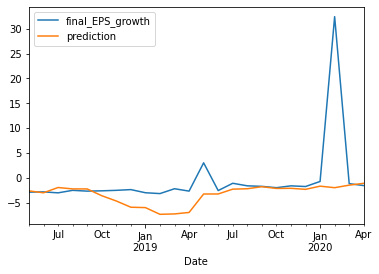

In [132]:
plot.plot()

In [133]:
yhat_1 = k_n_regressor.predict(test_X_1)
yhat_2 = k_n_regressor.predict(test_X_2)

<AxesSubplot:xlabel='Date'>

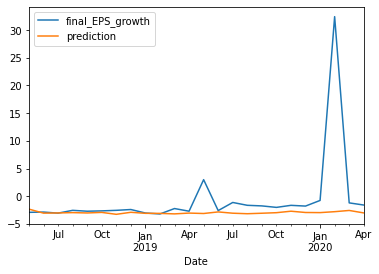

In [134]:
k_n_regressor = np.concatenate([yhat_1, yhat_2], axis=1)
plot = test_data.loc[:,['Date','final_EPS_growth']].set_index('Date')
plot['prediction'] = k_n_regressor[0]
plot.plot()

In [135]:
yhat_1 = tree_regressor.predict(test_X_1)
yhat_2 = tree_regressor.predict(test_X_2)

<AxesSubplot:xlabel='Date'>

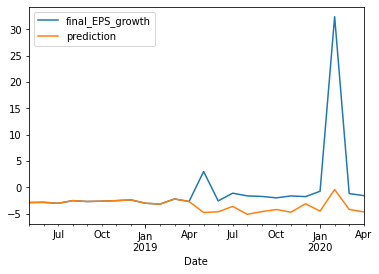

In [136]:
tree_reg_yhat = np.concatenate([yhat_1, yhat_2], axis=1)
plot = test_data.loc[:,['Date','final_EPS_growth']].set_index('Date')
plot['prediction'] = tree_reg_yhat[0]
plot.plot()